# Table of Contents
* [1. Quick start with ECEI2D package](#1.-Quick-start-with-ECEI2D-package)
	* [1.1 Initial setup and importing ECEI2D modules](#1.1-Initial-setup-and-importing-ECEI2D-modules)
	* [1.2 Gaussian Antenna detector](#1.2-Gaussian-Antenna-detector)
	* [1.3 Single channel ECE2D diagnosis](#1.3-Single-channel-ECE2D-diagnosis)
		* [1.3.1 Diagnose with a user set mesh](#1.3.1-Diagnose-with-a-user-set-mesh)
		* [1.3.2 Automatically adjust stepsize](#1.3.2-Automatically-adjust-stepsize)
		* [1.3.3 Information about diagnosing locations](#1.3.3-Information-about-diagnosing-locations)
	* [1.4 Multi-channel ECE Imaging](#1.4-Multi-channel-ECE-Imaging)
		* [1.4.1 Initialization](#1.4.1-Initialization)
		* [1.4.2 Diagnose and examine the result](#1.4.2-Diagnose-and-examine-the-result)
		* [1.4.3 Parallel execute](#1.4.3-Parallel-execute)
* [2. Benchmarks and Error Assessment](#2.-Benchmarks-and-Error-Assessment)
	* [2.1 Higher harmonic effects](#2.1-Higher-harmonic-effects)
	* [2.2 Error analysis](#2.2-Error-analysis)
	* [2.3 Anisotropic formulism(NOT FINISHED)](#2.3-Anisotropic-formulism%28NOT-FINISHED%29)


# Quick start with ECEI2D package

## Initial setup and importing ECEI2D modules

In [1]:
# Some initial setups
from __future__ import print_function
import sys

import numpy as np
from scipy.integrate import trapz, cumtrapz
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sdp.settings.unitsystem import cgs
import sdp.plasma.analytic.testparameter as tp
from sdp.plasma.character import PlasmaCharProfile

%matplotlib inline

rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 18

c = cgs['c']
keV = cgs['keV']
e = cgs['e']
me = cgs['m_e']

# We will use a uniform Te profile to do the benchmarks
Te0 = 10*keV
ne0 = 2e13
tp.set_parameter2D(Te_0 = Te0, ne_0=ne0, Te_shape='uniform', ne_shape='Hmode')
p2d_uni = tp.create_profile2D()
p2d_uni.setup_interps()

pcp_uni = PlasmaCharProfile(p2d_uni)

Not used params: {}


`sdp.diagnostics.ecei.ecei2d` package has mainly three core modules: `ece`, `imaging`, and `detector2d`. They provide three core classes, `ECE2D`, `ECEImagingSystem`, and `GaussianAntenna`, respectively. These three classes are also preloaded in the `ecei2d` package. So you can directly import them from `ecei2d` as in the cell below.

Class `ECE2D` carries out a single ECE diagnostic process, `ECEImagingSystem` provides standard methods to initialize and run an array of `ECE2D` objects, and `Detector2D` is a base class for 2D detectors, `GaussianAntenna` is the most commonly used derived class. 

In [2]:
from sdp.diagnostic.ecei.ecei2d import ECE2D, ECEImagingSystem, GaussianAntenna

## Gaussian Antenna detector

`GaussianAntenna` simulates an antenna pattern that can be described as a Gaussian Beam <a name="ref-1"/>[(Svelto, 2010)](#cite-svelto2010principles). 
In addition to a single frequency, it accepts a list of frequencies, a list of wave vectors, and a list of corresponding receiving(emitting) powers. This provides a fully customizable frequency bandwidth and shape. 
Any other keyword arguments passed in the constructor will be given to `sdp.model.lightbeam.GaussianBeam` constructor. In particular, three arguments are required: `waist_x`, `waist_y`, `w_0y`.  

In [3]:
R0 = tp.Parameter2D['R_0']
# calculate the local electron cyclotron frequency using the PlasmaCharProfile class
pcp_uni = PlasmaCharProfile(p2d_uni)
Z = [0]
R = [R0]
pcp_uni.set_coords([Z,R])

omega = 2*pcp_uni.omega_ce[0]
print('2nd ECE harmonic frequency: {0} (rad/s)'.format(omega))

2nd ECE harmonic frequency: 7.03531823569e+11 (rad/s)


In [4]:
k = omega/c
# single frequency detector
detector = GaussianAntenna(omega_list=[omega], k_list=[k], power_list=[1], waist_x=175, waist_y=0, w_0y=2)

## Single channel ECE2D diagnosis

`ece` module provides `ECE2D` class that represents a single channel diagnosis. 

It is initialized with a ECEI plasma profile, a `Detector2D` detector, a specified polarization, and 4 parameters determining the model used for current correlation tensor formula and dielectric tensor formula. Namely, they are `max_harmonic`, `max_power`, `weakly_relativistic` and `isotropic`. The first two are integers. They determine the highest harmonic frequency and highest order in FLR effect included in both current correlation tensor and dielectric tensor. The `weakly_relativistic` paramter is boolean, if `True`, weakly relativistic formula will be used, otherwise non-relativistic formula instead. `isotropic` is also boolean, `True` indicates the electron distribution is assumed isotropic, and the current correlation tensor can be easily obtained from anti-Hermitian part of corresponding dielectric tensor. 

> Right now, only isotropic plasma is implemented. 

In [5]:
ece = ECE2D(plasma=p2d_uni, detector=detector, polarization='X', max_harmonic=2, max_power=2, 
                weakly_relativistic=True, isotropic=True)

Propagator 2D initialized.


### Diagnose with a user set mesh

After initialization, a set of coordinates needs to be specified for ECE2D, as an initial mesh for preliminary calculations. `set_coords(coords)` method accepts a list of 1D coordinates, and will generate the 3D mesh used for ECE diagnosis.

In [6]:
X1D = np.linspace(250, 150, 100)
Y1D = np.linspace(-20, 20, 65)
Z1D = np.linspace(-20, 20, 65)

# set_coords needs to be called before running any other methods in ECE2D
ece.set_coords([Z1D, Y1D, X1D])

We can directly diagnose the plasma with this simple mesh, just call `diagnose` method. 

Three parameters are accepted in `diagnose`: `time`, `debug` and `auto_patch`. 
- `time`: integer, specifies the time step of plasma fluctuation that should be used for diagnosis, if not given, equilibrium plasma will be used.
- `debug`: bool, if True, a lot of extra information will be stored after diagnosis, for further investigation.
- `auto_patch`: bool, if True, program will try to optimize the grid in X direction, make finer mesh where emission is coming, and coarser mesh where wave propagates with no absorption or emission. A better way of doing this is calling `auto_adjust_mesh` method, with a tunable fine structure constant.

In [7]:
# we diagnose the equilibrium plasma with no auto coordinates adjustment. Keep more information by setting debug=True
Te = ece.diagnose()

Diagnose starts.
f = 112.0GHz starts.
Walltime: 5.542s


In [8]:
Te/keV

9.4347449119170843

> Note that the diagnosed Te is smaller than real Te, which is 10keV. The reason is our preset coordinates in X is too coarse within the emission area, thus not sampling enough data. Integration error is large due to this under sample situation. The way to improve this is to call `auto_adjust_mesh` method.

We can take a look at where received emission is coming from by examine the `integrand_list`.

In [9]:
emission_spot = ece.view_spot

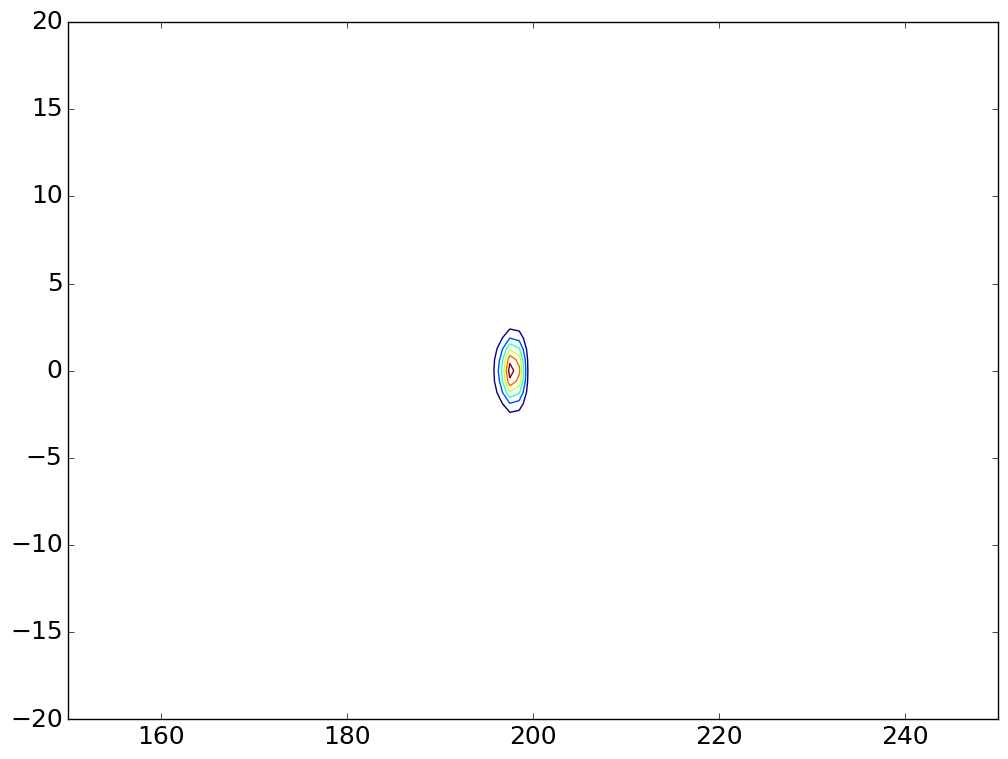

In [10]:
plt.contour(ece.X1D, ece.Y1D, emission_spot[:,:], N=20)

### 1.3.2 Automatically adjust stepsize

`ECE2D` has `auto_adjust_mesh` method that will automatically choose proper grid points on X direction. The way it does this is run a preliminary propagation on the original mesh, and calculate the actual emission locations that antenna sees. Make fine mesh within these regions, and setup coarser mesh outside them. 

Default parameters are:
- emission region boundaries: The emission regions are determined by finding locations where receiving strength is larger than $e^{-9}$ maximum strength. In other words, roughly 3 standard deviations away if Gaussian shape is assumed.
- fine mesh step size: By default, inside emission regions, step size in X is set to be $0.5\lambda_0$, with $\lambda_0$ the vacuum wave length. This can be tuned using `fine_coeff` argument. For example, `fine_coeff`=2 means steps size is half of the default.
- coarse mesh step size: Outside the emission regions, step size is set to be $5\lambda_0$. It is also changed with `fine_coeff` argument. So the ratio between fine and coarse step size is always 0.1 .

In [11]:
ece.auto_adjust_mesh(fine_coeff=1)

Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 5.389s


In [12]:
ece.X1D.shape

(118L,)

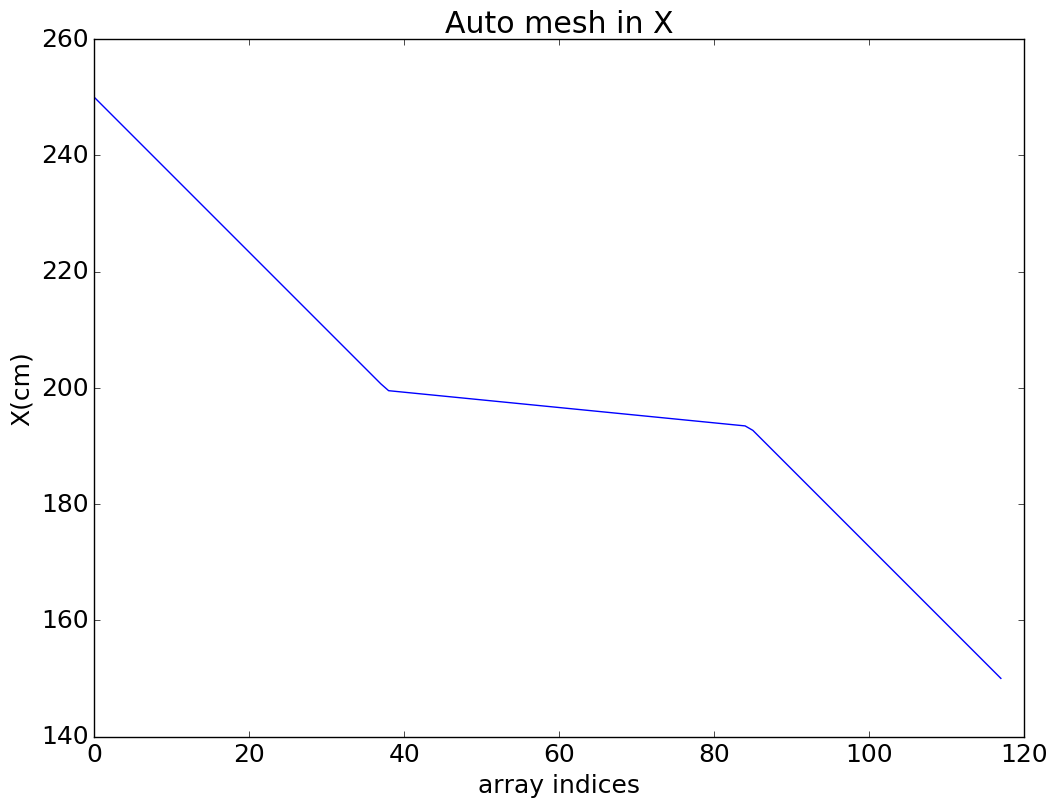

In [13]:
plt.plot(ece.X1D)
plt.xlabel('array indices')
plt.ylabel('X(cm)')
plt.title('Auto mesh in X')

The total mesh points is less, but more focused in emission area. How about the performance?

In [14]:
ece.diagnose()

Diagnose starts.
f = 112.0GHz starts.
Walltime: 6.263s


1.6001772617758013e-08

In [15]:
ece.Te/keV

9.9873752451366951

Now, the result is roughly 50 times more accurate with only 1.5 times mesh points! 

> It is recommended to always use `auto_adjust_mesh` before `diagnose`, or simply set `auto_patch=True` when calling `diagnose`.

### Information about diagnosing locations

A useful information is where our signal comes from. `ECE2D` provides three ways to access this.
- view_point: the coordinates (Z, Y, X) of the highest receiving strength, which is presumabily the best estimation of the actual center of the emission signal.
- view_spot : the 2D array containing emission intensity distribution over Y-X plane. Plot can be made showing the location and shape of spot.
- diag_x: gives a detailed information of locations in X where significant contributions of emission power are from. list of centers and *half widths* are returned.

In [16]:
ece.view_point

(0.0, 0.0, 197.47474747474746)

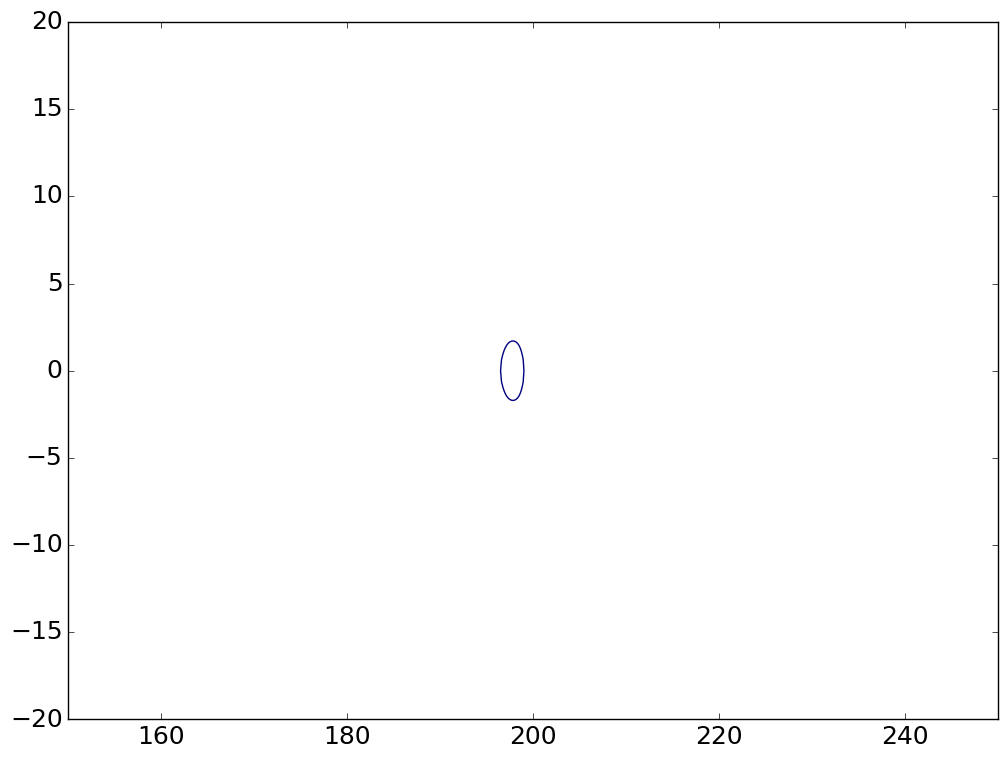

In [17]:
vs = ece.view_spot
# draw the 1/e boundary of the emission spot
plt.contour(ece.X1D, ece.Y1D, vs, (0.368*np.max(vs),))

In [18]:
xs, dxs = ece.diag_x
print(xs, dxs)

[196.46464646464645] [1.0101010101010104]


As we can see, the center of the emission region may not be the same as the strongest emission location. This is due to the uneven shape of the spot. The *half width* is a very rough estimation of the $1/e$ width of the spot, but can give us a sense of the resolution in X.

## Multi-channel ECE Imaging

Multi-channel ECE Imaging capability is provided in module `sdp.diagnostic.ece.ecei2d.imaging`, class `ECEImagingSystem`.

In [19]:
from sdp.diagnostic.ecei.ecei2d.imaging import ECEImagingSystem

### Initialization

`ECEImagingSystem` is initialized in a similar way as `ECE2D`. The only difference is that it accepts a list of `Detector2D` detectors instead of only one as in `ECE2D` case.

In [20]:
# the referece frequency
omega = 2*pcp_uni.omega_ce[0]
# generate 4 frequencies span from 0.8 to 1.1 times reference frequency
omega_s = np.linspace(0.8, 1.1, 4)*omega
k_s = omega_s/c
# a list of detectors generated for each (omega,k) pair
detectors = [GaussianAntenna(omega_list=[f], k_list=[k_s[i]], 
                             power_list=[1], waist_x=175, waist_y=0, 
                             w_0y=2) for i, f in enumerate(omega_s)]

In [21]:
print(omega_s)

[  5.62825459e+11   6.33178641e+11   7.03531824e+11   7.73885006e+11]


In [22]:
ecei = ECEImagingSystem(plasma=p2d_uni, detectors=detectors, 
                        polarization='X', max_harmonic=2, 
                        max_power=2, weakly_relativistic=True, 
                        isotropic=True)

Propagator 2D initialized.
Propagator 2D initialized.
Propagator 2D initialized.
Propagator 2D initialized.


After Initialization, setting coordinates and automatic adjustment have almost the same signitures as in `ECE2D`, with additional option of choosing channels. Default is to choose all available channels.

In [23]:
# this channelID is the default
ecei.set_coords([Z1D, Y1D, X1D], channelID='all') 
# Or, we can specify a list of channels
ecei.set_coords([Z1D, Y1D, X1D], channelID=[0,1])

In [24]:
# automatic adjustment can also be done for chosen channels.
ecei.auto_adjust_mesh(0.5, channelID=[0,1])
ecei.auto_adjust_mesh(1, channelID=[2,3])
# we can check the grid points number for each channel
for i,channel in enumerate(ecei.channels):
    print('channel #{0}: NX = {1}'.format(i, channel.NX))

Serial run of channel [0, 1] out of total 4 channels.
Channel 0:
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 5.167s
Channel 1:
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 5.203s
Walltime: 10.38s
Serial run of channel [2, 3] out of total 4 channels.
Channel 2:
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 5.134s
Channel 3:
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 5.113s
Walltime: 10.26s
channel #0: NX = 49
channel #1: NX = 55
channel #2: NX = 118
channel #3: NX = 130


We can see the first two channels have coarser mesh because the adjustment coefficient is 0.5.

### Diagnose and examine the result

`ECEImagingSystem`'s diagnose method has basically the same signature as `ECE2D`, with the additional option of choosing channels.

In [25]:
ecei.diagnose(channelID='all')

Serial run for channel [0 1 2 3] out of total 4 channels.
Channel #0:
Diagnose starts.
f = 89.58GHz starts.
Walltime: 2.557s
Channel #1:
Diagnose starts.
f = 100.8GHz starts.
Walltime: 2.843s
Channel #2:
Diagnose starts.
f = 112.0GHz starts.
Walltime: 6.138s
Channel #3:
Diagnose starts.
f = 123.2GHz starts.
Walltime: 6.77s
Walltime: 18.33s


Result can be examined as same as in `ECE2D` case.

In [26]:
ecei.Te/keV

array([ 9.93533592,  9.94846304,  9.98737525,  9.98909864])

Again, we see a finer mesh gives us better accuracy.

Viewing spots information is stored in `view_spots`, `view_points`, and `diag_x`.

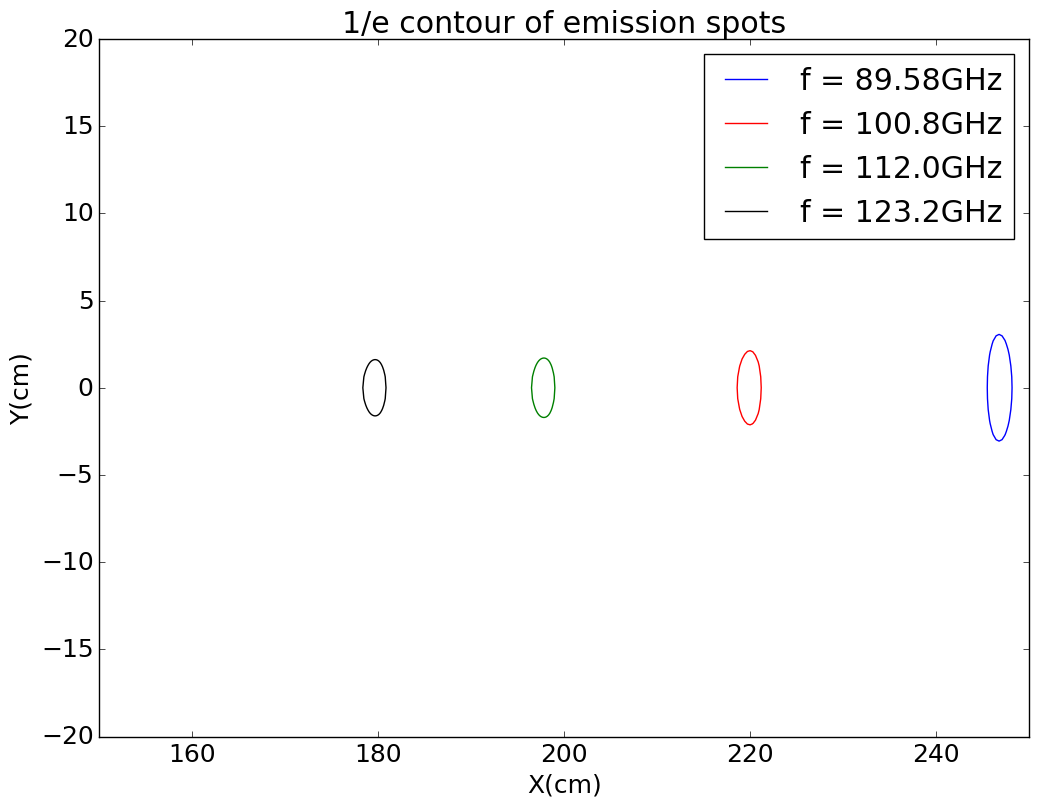

In [27]:
# we draw the view spots of all channels on one plot
plt.figure()
color_list = ['b', 'r', 'g', 'k']
lines = []
labels = []
for i,vs in enumerate(ecei.view_spots):
    X1D = ecei.X1Ds[i]
    Y1D = ecei.Y1Ds[i]
    ctr = plt.contour(X1D, Y1D, vs, (0.368*np.max(vs),), 
                     colors=color_list[i%4])
    lines.append(ctr.collections[0])
    # convert angular frequency (rad/s) to Giga-Hertz
    labels.append('f = {0:.4}GHz'.format(omega_s[i]/(2*np.pi)*1e-9))
plt.legend(lines, labels)
plt.xlabel('X(cm)')
plt.ylabel('Y(cm)')
plt.title('1/e contour of emission spots')

### Parallel execution

`ECEImagingSystem` supports IPython/Jupyter style parallelization. Check out https://ipyparallel.readthedocs.org/en/latest/ for more details about starting IPython clusters. 

After starting IPython cluster on you machine/server, you can get a Client handler by calling `ipyparallel.Client()`.

In [28]:
import ipyparallel as ipp
client = ipp.Client()

Then, initialize `ECEImagingSystem` with `parallel=True`, and `client=client`.

In [29]:
ecei_para = ECEImagingSystem(plasma=p2d_uni, detectors=detectors, 
                        polarization='X', max_harmonic=2, 
                        max_power=2, weakly_relativistic=True, 
                        isotropic=True, parallel=True, client=client)

Now, setting up coordinates, automatically adjust mesh, and diagnose have exactly the same signitures as those in serial version.

In [30]:
ecei_para.set_coords([Z1D, Y1D, X1D])

[<AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>]

In [31]:
ecei_para.auto_adjust_mesh()

Parallel run of channel [0 1 2 3] on 4 engines.
channel #0 on engine #0.
channel #1 on engine #1.
channel #2 on engine #2.
channel #3 on engine #3.
Walltime: 9.6s


[<AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>]

In [32]:
ecei_para.diagnose()

Parallel run for 4 channels on 4 engines.
Channel #0 on engine #0
Channel #1 on engine #1
Channel #2 on engine #2
Channel #3 on engine #3
Walltime: 8.588s


[<AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>,
 <AsyncResult: execute:finished>]

Checking basic information is also the same.

In [33]:
print(ecei_para.Te/keV)

[ 9.97891849  9.98789938  9.98290839  9.98906351]


In [34]:
view_spots = ecei_para.view_spots

However, information accessable through `channels` attribute is a little trickier, because all the actual "channel" objects are scattered on different engines in parallel mode, and they are not serializable. The parallel version has a nominal `channels` attribute, which collects important channel data from remote engines, but they are no longer the actual "ECE2D" objects that run the diagnostics. They are just data containers with type `ECE2D_property`.

In [35]:
channels = ecei_para.channels

Parallel Channels:
    channel 0 on engine 0:
        received.
    channel 1 on engine 1:
        received.
    channel 2 on engine 2:
        received.
    channel 3 on engine 3:
        received.


These "ECE2D_property" objects have very similar attribute names as "ECE2D" objects.  

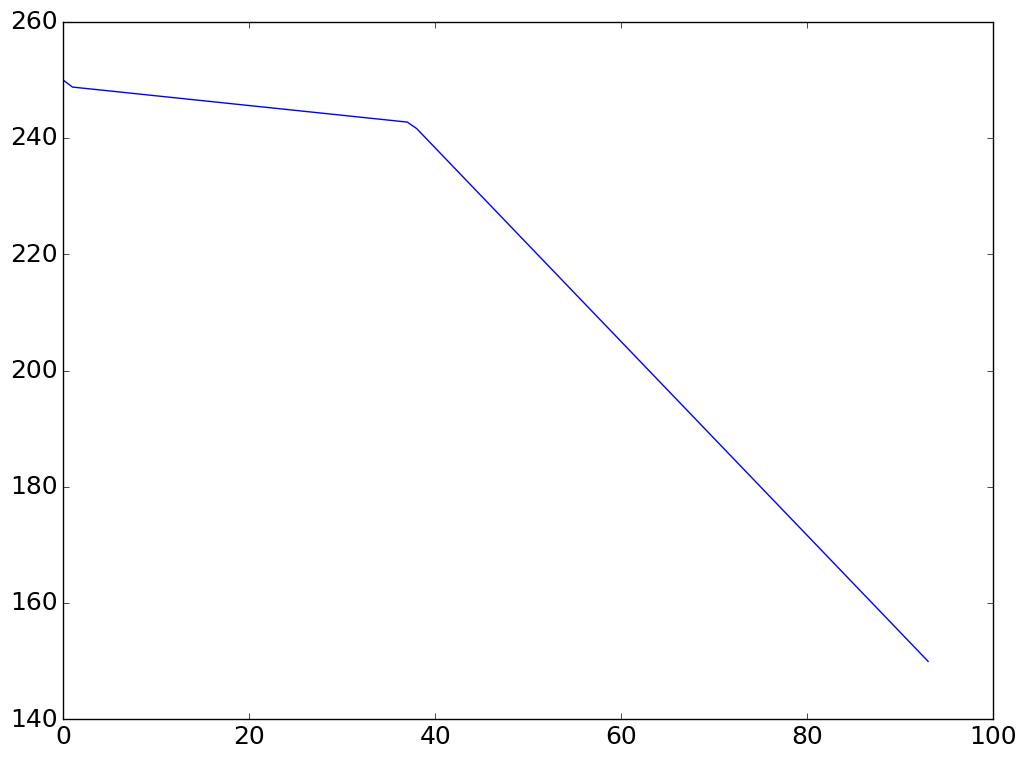

In [36]:
c0 = channels[0]
X1D = c0.X1D

plt.plot(X1D)

They also have flags indicating the running mode of the "ECE2D" object.

In [37]:
print('Coords_set: {0}\n'.format(c0.is_coords_set()), 
      'Auto_mesh_adjusted: {0}\n'.format(c0.is_auto_adjusted()),
      'Diagnosed: {0}\n'.format(c0.is_diagnosed()),
      'Debug: {0}\n'.format(c0.is_debug())
      )

Coords_set: True
 Auto_mesh_adjusted: True
 Diagnosed: True
 Debug: False



# 2. Benchmarks and Error Assessment

In this section, we'll show effects of higher harmonics, as well as the sensibility of the diagnostic accuracy on mesh resolution.

## Higher harmonic effects

Higher harmonic may come in when temperature is high and relativistic downshift effect is significant. In our test case, 3rd harmonic resonance has a finite absorption layer at the outer edge of plasma.

In [38]:
omega_3rd = 8e11
k_3rd = omega_3rd/c
# single frequency detector
detector_3rd = GaussianAntenna(omega_list=[omega_3rd], k_list=[k_3rd], power_list=[1], waist_x=175, waist_y=0, w_0y=2)

In [39]:
# Note that we need to change max_harmonic and max_power to at least 3 for studying 3rd harmonic effects
ece_3rd = ECE2D(plasma=p2d_uni, detector=detector_3rd, polarization='X', max_harmonic=3, max_power=3, 
                weakly_relativistic=True, isotropic=True)

Propagator 2D initialized.


In [40]:
ece_3rd.set_coords([Z1D, Y1D, X1D])

In [41]:
ece_3rd.diagnose(debug=True, auto_patch=True)
print(ece_3rd.Te/keV)

Diagnose starts.
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 7.905s
f = 127.3GHz starts.
Walltime: 47.05s
9.99044213756


We can now look at the emission pattern in X-Y plane

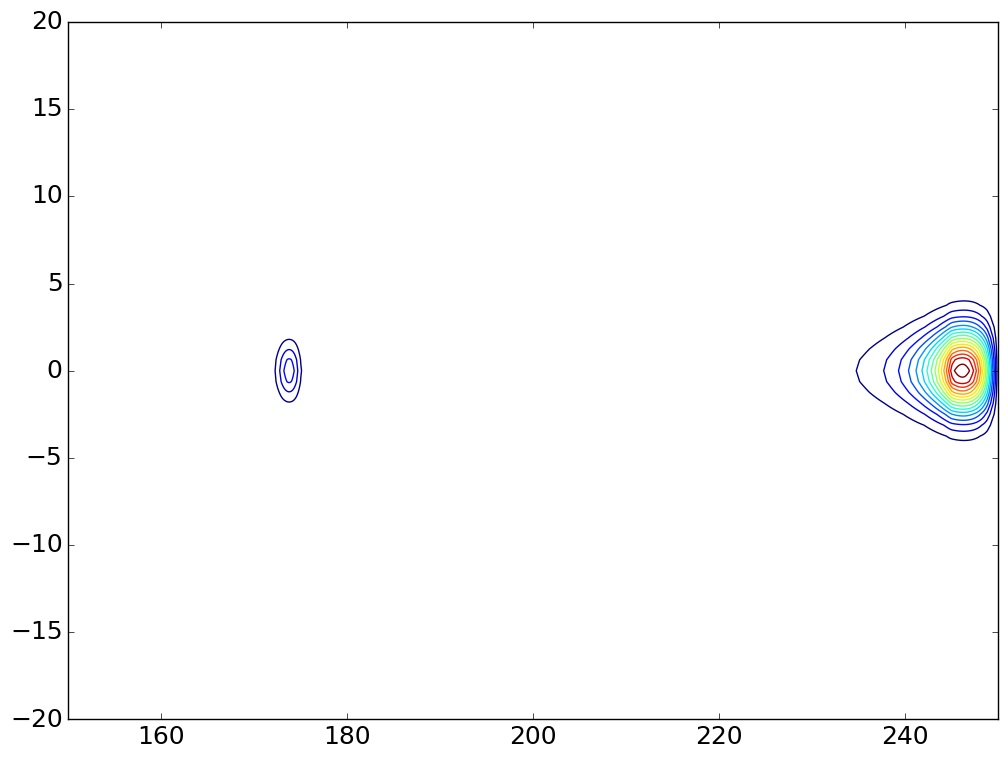

In [42]:
plt.contour(ece_3rd.X2D, ece_3rd.Y2D, ece_3rd.view_spot, 20)

It shows that main contribution is actually from the edge 3rd harmonic resonance layer. Locations can be verified with `view_point` (strongest emission location) and `diag_x` (main emission sources) attributes.

In [43]:
ece_3rd.view_point

(0.0, 0.0, 246.11780455153951)

In [44]:
ece_3rd.diag_x

([227.73092369477914, 171.66666666666669],
 [7.0214190093708169, 1.1111111111111096])

This will significantly affect final result if we have a non-uniform electron temperature.

In [45]:
tp.set_shape2D('Hmode','PedWidthT',0.1)
tp.set_shape2D('Hmode','PedHightT',0.7)
tp.set_parameter2D(Te_0=10.0*keV, Te_shape='Hmode')
p2d_hmode = tp.create_profile2D()
p2d_hmode.setup_interps()

Not used params: {}


In [46]:
# examine the profile parameters
print(p2d_hmode)

Electron Cyclotron Emission Imaging plasma Profile:

Unit System:cgs
Length: centi-meter
Mass: gram
Time: second

Grid:2D Cartesian Grids
DownLeft :(-30, 150)
UpRight :(30, 300)
NR,ResR :(601, 0.24958402662229617)
NZ,ResZ :(720, 0.08333333333333333)

Physical Quantities:
Equilibrium:
    Electron density: ne0 (max: 2e+13, min:2e+03 cm^-3)
    Electron temperature: Te0 (max:10.0, min:1e-09 keV)
    Magnetic field: B0 (max:2.67e+04, min:1.33e+04 Gauss)
Fluctuation:




The electron temperature is gradually decreasing from the center up to the pedestal top, and rapidly getting to zero with in the pedestal.

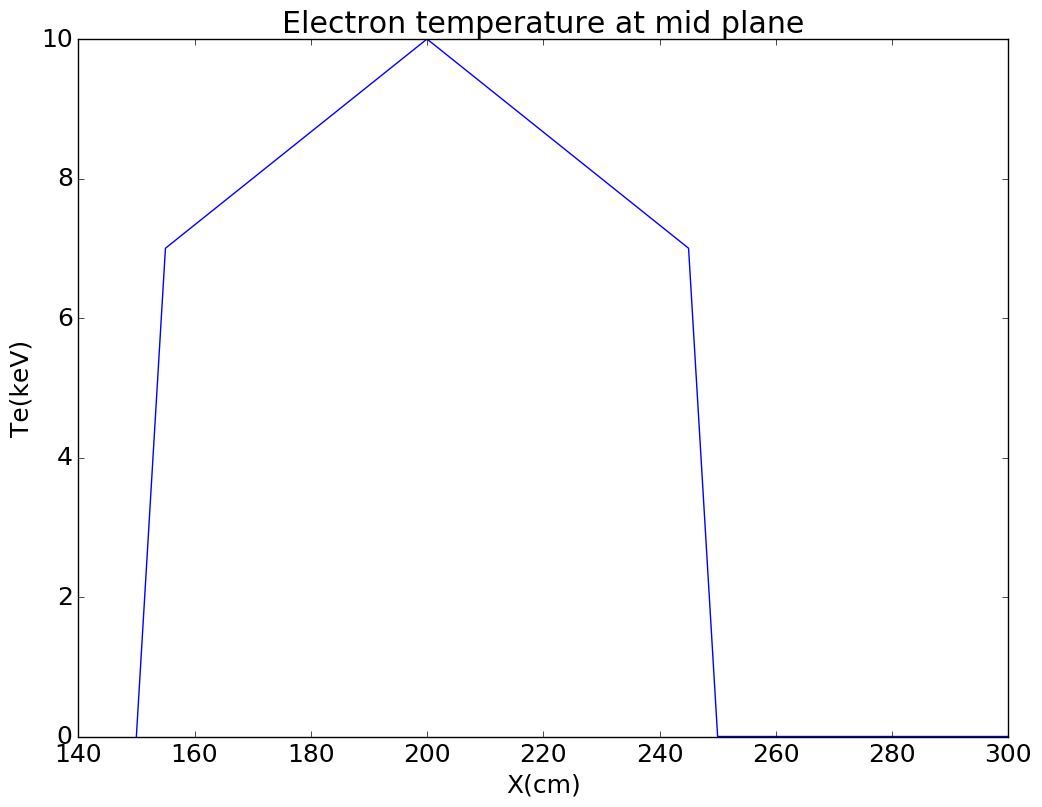

In [47]:
Z_mid = p2d_hmode.grid.NZ/2
plt.plot(p2d_hmode.grid.R1D, p2d_hmode.Te0[Z_mid, :]/keV)
plt.title('Electron temperature at mid plane')
plt.ylabel('Te(keV)')
plt.xlabel('X(cm)')

In [48]:
ece3_hmode = ECE2D(plasma=p2d_hmode, detector=detector_3rd, polarization='X', max_harmonic=3, max_power=3, 
                weakly_relativistic=True, isotropic=True )

Propagator 2D initialized.


In [49]:
ece3_hmode.set_coords([Z1D, Y1D, X1D])
ece3_hmode.diagnose(auto_patch=True)

Diagnose starts.
Automatic coordinates adjustment performed! To reset your mesh, call set_coords() with initial mesh again.
Walltime: 8.36s
f = 127.3GHz starts.
Walltime: 53.92s


1.2056635618229148e-08

In [50]:
ece3_hmode.Te/keV

7.5250503172070582

The measured Te is much smaller than the value at the aimed 2nd harmonic layer location. There is an additional emission region near the top of the pedestal(~ 240cm).

In [51]:
print('view_point:{0}\ndiag_x:{1}'.format(ece3_hmode.view_point, ece3_hmode.diag_x))

view_point:(0.0, 0.0, 173.33333333333334)
diag_x:([223.31325301204822, 171.66666666666669], [8.3266398929049554, 1.1111111111111096])


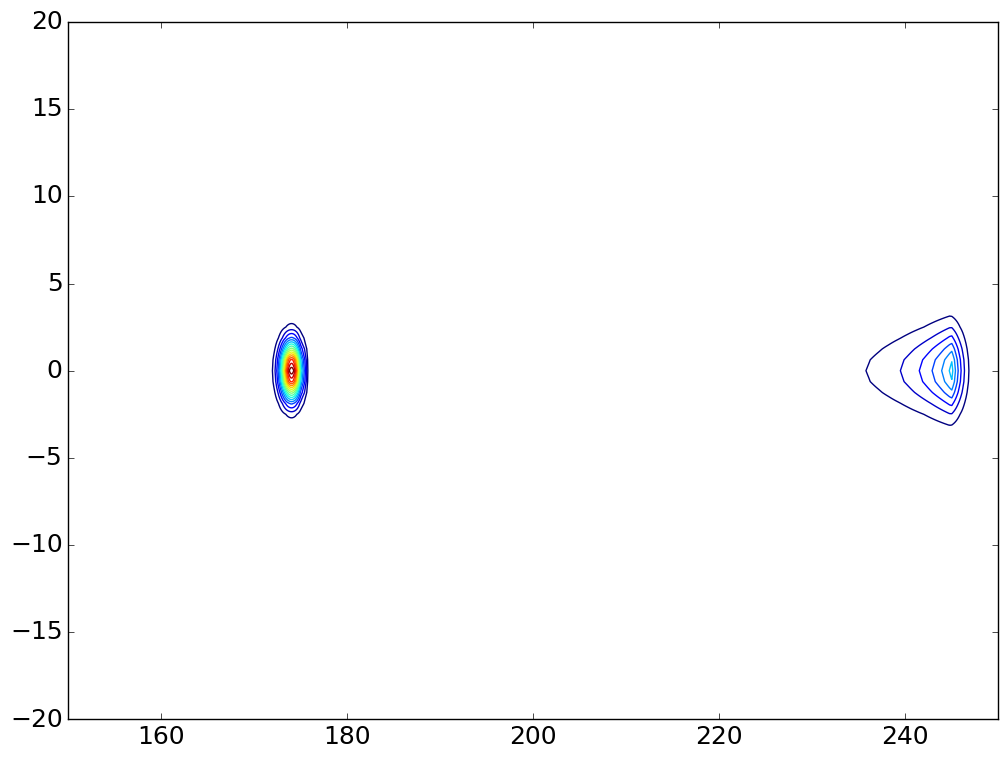

In [52]:
plt.contour(ece3_hmode.X2D, ece3_hmode.Y2D, ece3_hmode.view_spot, 20)

The local temperatures at the view point and the center of the spot are:

In [53]:
Te_2nd, Te_3rd = p2d_hmode.get_Te([[0,0],[ece3_hmode.view_point[2], 240]])/keV

print('2nd harmonic Te: {0:.4} keV \n 3rd harmonic Te: {1:.4} keV \n Te obtained from ECE: {2:.4} keV'.format(Te_2nd, Te_3rd, ece3_hmode.Te/keV))

2nd harmonic Te: 8.222 keV 
 3rd harmonic Te: 7.333 keV 
 Te obtained from ECE: 7.525 keV


Our measured temperature is between the expected 2nd Harmonic Te and the 3rd Harmonic Te.

## Error analysis

First, let's take a look at the error dependency on step sizes. We'll use the 2nd harmonic version, and uniform plasma in this section.

In [54]:
base = 4
power_list = np.arange(5)*0.5
err_list = np.empty_like(power_list, dtype='float')
for i,p in enumerate(power_list):
    step_yz = int(2**(base+p))
    Y1D = np.linspace(-20, 20, step_yz+1)
    Z1D = np.linspace(-20, 20, step_yz+1)
    ece.auto_adjust_mesh(fine_coeff=2**p/4)
    ece.set_coords([Z1D, Y1D, ece.X1D])
    # each time set_coords is called, auto_coords_adjusted flag will be reset. 
    # Here we'll manually set it to save some time.
    ece._auto_coords_adjusted = True
    ece.diagnose()
    err_list[i] = 1 - ece.Te/Te0 

Diagnose starts.
f = 112.0GHz starts.
Walltime: 0.6094s
Diagnose starts.
f = 112.0GHz starts.
Walltime: 0.9788s
Diagnose starts.
f = 112.0GHz starts.
Walltime: 1.967s
Diagnose starts.
f = 112.0GHz starts.
Walltime: 3.743s
Diagnose starts.
f = 112.0GHz starts.
Walltime: 6.645s


In [55]:
err_list

array([ 0.01560076,  0.00805625,  0.00389254,  0.00165081,  0.00084542])

In [56]:
from scipy.stats import linregress
slope, intercept, r, p, stderr = linregress(power_list*np.log(2), np.log(np.abs(err_list)))
x = power_list*np.log(2)
y = np.exp(slope*x + intercept)

In [57]:
slope

-2.1397056320557377

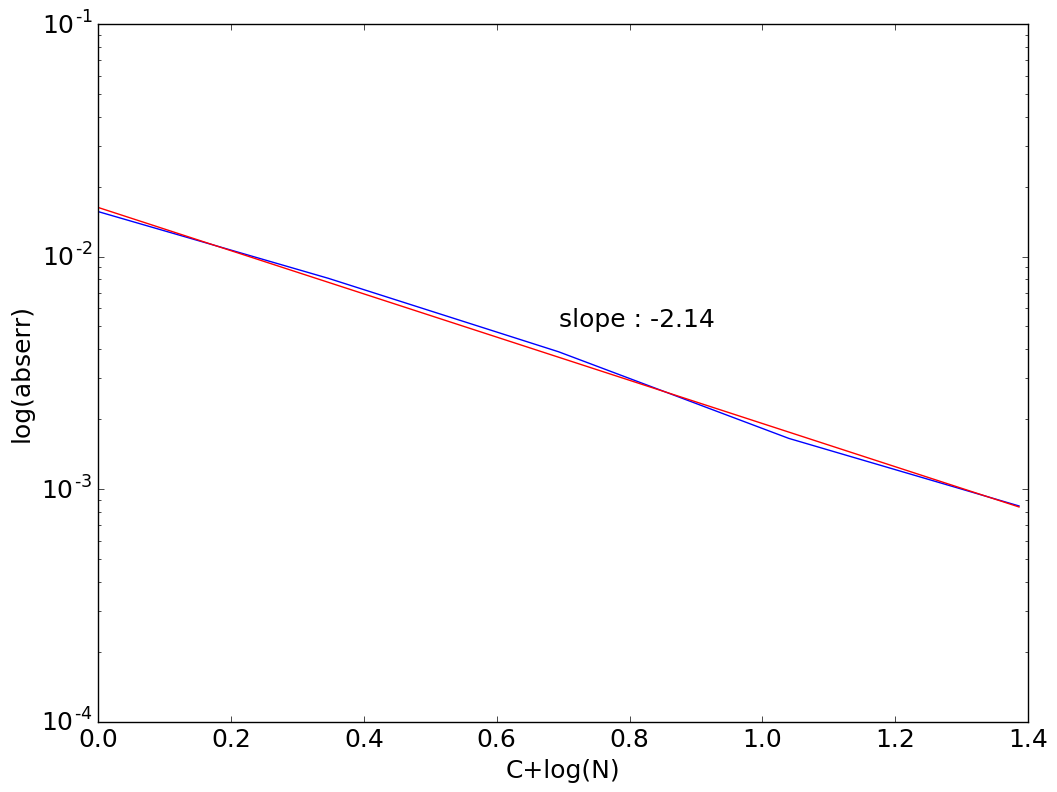

In [58]:
plt.semilogy(x, np.abs(err_list))
plt.semilogy(x, y, 'r')
plt.text(x[2], 5e-3, 'slope : {0:.3}'.format(slope))
plt.xlabel('C+log(N)')
plt.ylabel('log(abserr)')

The error drops as square of step size, just as expected.

## Anisotropic formulism(NOT FINISHED)

Anisotropic formulism of dielectric tensor and current correlation tensor has only been available for non-relativistic cases. The validity criteria for non-relativistic limit is:

$$ \frac{k_\parallel v_{th \parallel}}{\omega} > \mu $$

where $v_{th\parallel} \equiv 2T_{e\parallel}/m_e$ is the parallel thermal velocity, and $\mu \equiv T_e/m_e c^2$ the normal relativistic parameter.

This criteria can also be written as:

$$ N_\parallel > \frac{v_{th \parallel}}{2c}$$

where $N_\parallel \equiv ck_\parallel/\omega$ is the parallel component of refractive index. 

This is a requirement of a finite $k_\parallel$. For a 10keV plasma, this roughly corresponds to $N_\parallel > 1/7 \sim \pi/22$. So, in the rest of this section, we will use a detector that is slightly tilted horizontally with an angle of $\pi/15$. We also choose a larger beam waist width in Z direction to lower the spread in $k_z$ space. 

In [ ]:
detector1 = GaussianAntenna(omega_list=[omega], k_list=[k], 
                            power_list=[1], 
                            waist_x=172, waist_y=0, waist_z=2, 
                            w_0y=2, w_0z=5, 
                            tilt_v=0, tilt_h=np.pi/20)

> One tricky part for propagation with a finite tilted angle is that the paraxial approximation we've made. This approximation is only accurate up to $o(N_\parallel^2)$, in this case, $\sim 0.02$. This might not be accurate enough for diagnosing small perterbations. A quick fix to this is done by taking into account the actual light path length within one step size in X, and calculate the wave field absorption acoording to this length. This gives us a much better result for ECE diagnostic.

In [ ]:
tp.set_parameter2D(Te_0 = 10*keV, Te_shape='uniform', ne_shape='Hmode', 
                   dte_te=0.2, dne_ne=0.1, dB_B=0, NR=100, NZ=40, 
                   DownLeft=(-40, 100), UpRight=(40, 300), 
                   timesteps=np.arange(5) )
p2d = tp.create_profile2D(fluctuation=True)
p2d.setup_interps()

In [ ]:
# isotropic formulism
ece_iso = rcp.ECE2D(plasma=p2d, detector=detector1, polarization='X', 
                    max_harmonic=2, max_power=2, weakly_relativistic=False, 
                    isotropic=True)

# anisotropic one
ece_ani = rcp.ECE2D(plasma=p2d,detector=detector1, polarization='X', 
                    max_harmonic=2, max_power=2, weakly_relativistic=False, 
                    isotropic=False)

> A finite $k_z$ requires much more finer grid in Z direction. And since the beam is tilted, a wider area of calculation is also necessary.

<!--bibtex

@book{svelto2010principles,
  title={Principles of Lasers},
  author={Svelto, O.},
  isbn={9781441913029},
  lccn={2009940423},
  url={https://books.google.com/books?id=ioywRI5W2HEC},
  year={2010},
  publisher={Springer US},
  pages={153--155}
}

@misc{wiki:gaussian_beam,
   author = "Wikipedia",
   title = "Gaussian beam --- Wikipedia{,} The Free Encyclopedia",
   year = "2016",
   url = "https://en.wikipedia.org/w/index.php?title=Gaussian_beam&oldid=703704493",
   note = "[Online; accessed 17-March-2016]"
 }

-->

# References

<a name="cite-svelto2010principles"/><sup>[^](#ref-1) </sup>Svelto, O.. 2010. _Principles of Lasers_. [URL](https://books.google.com/books?id=ioywRI5W2HEC)

